## 0.1 Installing Modules

#### Installing facebook forecasting algorithm "prophet"

In [1]:
#!pip install pystan==2.19.1.1
#!pip install prophet
# OR
#!conda install gcc
#!conda install -c conda-forge prophet

## 0.2 Importing modules

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from IPython.display import clear_output as co
from sklearn.preprocessing import LabelEncoder as le

import tools # Personalized pythom module for the project

In [3]:
#from prophet import Prophet

## 0.3 Defining functions

---
# 1. Data cleaning and processing

### 1.1 Loading data

In [4]:
df = pd.read_csv('data/historical-database.csv', sep=';')
df.head(3)

,year,city_code,product_type,product,"destinated_area,"
0,01/01/1974,960b4f2c94a2fb2c,temporary,Others,"0,"
1,01/01/1974,746cc42bfb8f6b62,temporary,Others,"0,"
2,01/01/1974,6cce2bf873870afc,temporary,Others,"0,"


### 1.2 Data formatting

In [5]:
target = 'area'
data = df.copy()
#### Formatação do nome da coluna da variável alvo
data.rename(columns={'destinated_area,': target}, inplace=True)
#### Identificação de células vazias
data[target].replace(',', np.nan, inplace=True)
#### Conversão da variável alvo para float
data[target] = data[target].str.replace(',', '.').astype(float)
### Salvando dados limpos
#data.to_csv('data/historical-database-clean.csv', index=False)

### 1.3 Extracting yearly time series by city-type-product combinations

In [6]:
raw_series = tools.preprocess.extract_series(data, save=False)

### 1.4 Dealing with missing values:

1. Excluding series.
    * Excluindo séries para as quais a variável alvo está vazia para 2016 e 2017.
    * Excluindo séries para as quais a variável alvo com zero entradas no conjunto de treinamento (até 2015) (35 found).
2. Excluding first years.
    * Excluindo vazios ou zeros até "n" anos. (Análises univariadas)
    * Excluindo vazios ou zeros até "ni" anos para cada série. (Análises multivariadas)
3. Excluding/filling missing values.
    * Excluindo entradas vazias (opcional).
    * Preenchendo entradas vazias (opcional). 

In [13]:
series, excluded_test_index = tools.preprocess.clean_series(raw_series, train_min=1, drop_start_zeros=True, save=False, path='data/series clean/{}.csv')

Values Count:
n_total            1712
n_values_total    73744
n_values_test      3424
n_values_train    70320
dtype: int64

Excluded count:
series                     605
series_empty               442
series_test_empty          582
series_train_min_<_1       465
values                   40936
values_empty             39035
test_empty                1198
train_empty              37837
non_empty_values          1901
non_empty_test_values       35
n_train_zeros             4796
dtype: int64


#### Saving non empty excluded test values index

In [14]:
pd.Series(excluded_test_index, name='excluded_test_index').to_csv('data/excluded_test_index.csv', index=False)

### 1.5 Concatening remaining series into one table

In [7]:
X = tools.preprocess.concat_series(series, le_index=True, save=False, path='data/series.csv')
X_full = tools.preprocess.concat_series(raw_series, le_index=False, save=False, path='data/raw_series.csv')

---
# 2. Data Exploration
#### 2.0.1 Loading processed data

In [ ]:
data = pd.read_csv('data/historical-database-clean.csv')
X_full = pd.read_csv('data/raw_series.csv', index_col=0)
X = pd.read_csv('data/series.csv', index_col=0)
raw_series = tools.preprocess.load_series(path='data/series/')
series = tools.preprocess.load_series(path='data/series clean/')
keys = list(series.keys())

#### 2.0.2 Setting local variables

In [5]:
target = 'area'
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

### 2.1 Products statistical summary

In [35]:
data.groupby(['product', 'product_type']).describe()

area                                          \
                         count          mean            std        min   
product   product_type                                                   
Açaí      permanent      291.0   1686.230241    5245.467590   3.000000   
Beans     temporary     3414.0    565.310193     990.800160   0.000000   
Cassava   temporary     3848.0   2270.173857    3824.356790   1.000000   
Cocoa     permanent     1801.0   1109.669628    2933.876503   0.000000   
Corn      temporary     3739.0   2110.839262    4579.408423   1.000000   
Livestock pasture       4752.0  98051.332823  141783.939141  33.074823   
Others    permanent     6292.0    582.808964    1468.537558   0.000000   
          temporary     6292.0    133.125238     722.437937   0.000000   
Palm oil  permanent      521.0   2735.932821    4201.624180   0.000000   
Rice      temporary     3418.0   1646.812171    3698.659558   0.000000   
Sorghum   temporary        7.0   4435.000000    3299.412827  10.000000   
Soy       temporary      334.0   7214.934132   15696.564039   5.000000   

                                                                              
                                 25%          50%            75%         max  
product   product_type                                                        
Açaí      permanent        30.000000    130.00000     532.500000    40000.00  
Beans     temporary        70.000000    200.00000     600.000000    12240.00  
Cassava   temporary       380.000000   1000.00000    2500.000000    45000.00  
Cocoa     permanent        30.000000    111.00000     851.000000    38569.00  
Corn      temporary       150.000000    700.00000    2095.000000    98000.00  
Livestock pasture       13008.745125  47204.73691  127344.343025  1626070.83  
Others    permanent         0.000000     95.00000     538.000000    17491.00  
          temporary         0.000000      0.00000      52.000000    12500.00  
Palm oil  permanent       190.000000   1000.00000    3100.000000    21600.00  
Rice      temporary        50.000000    320.00000    1800.000000    60000.00  
Sorghum   temporary      2517.500000   5000.00000    6500.000000     8000.00  
Soy       temporary       270.000000    910.00000    7000.000000   122035.00

### 2.2 Missing values per year (before & after cleaning)

In [70]:
def missing_per_row(X):
    missing_per_year = []
    for index in X.index:
        row = X.loc[index]
        na_values = row.isna().sum()
        zeros = (row==0).sum()
        missing = na_values + zeros
        missing_per_year.append([missing, X.shape[1]-missing, missing/X.shape[1], na_values/X.shape[1], zeros/X.shape[1]])
    return pd.DataFrame(missing_per_year, columns=['missing', 'not_missing', 'missing (%)', 'na_values(%)', 'zeros(%)'])

def plot_missing(df):
    missing = missing_per_row(df)
    cols = [2,3,4]
    fig = plt.figure(figsize=(10,3), tight_layout=True)
    ax0, ax1 = [fig.add_subplot(1,2,i) for i in [1,2]]
    missing.iloc[:, cols].plot(marker='o', ms=4, title='Missing values per year', ax=ax0)
    ax0.set(ylabel='Missing values', xlabel='Year (1974 - 2017)')
    missing.cumsum().iloc[:, :2].plot(marker='o', ms=4, title='Cumulative sum of missing values per year', ax=ax1)
    ax1.set(ylabel='Missing values', xlabel='Year (1974 - 2017)')
    plt.show()

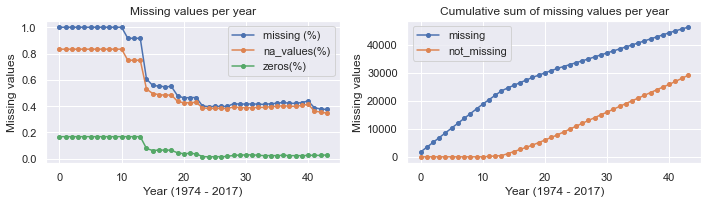

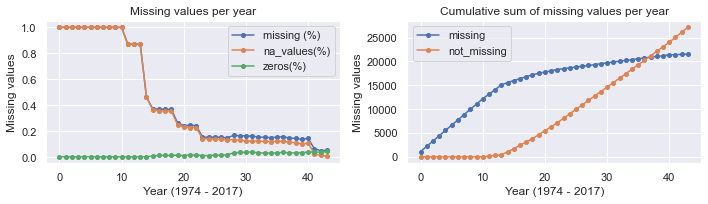

In [71]:
plot_missing(X_full)
plot_missing(X)

Conclusion:
    After the data cleaning process, each year is missing at least 85% of its values until the 13th indexed year, but miss only less then 40% from then on. So we can safely exclude the values for years before the 14th indexed year (1987).

### 2.3. Missing series per city

In [91]:
n_series_per_city = pd.Series(
    [data[data['city_code']==uni_city].groupby(['city_code', 'product', 'product_type']).sum().shape[0] for uni_city in data['city_code'].unique()],
    index=data['city_code'].unique(),
    name='city count'
).value_counts().to_frame()
n_series_per_city.index.name = 'nº of series'

In [92]:
n_series_per_city

,city count
nº of series,
12,138
11,5
1,1


#### Missing values per city_code:
* 138 cities have values for all 12 types-products
* 5 cities have values for 11 types-products
* 1 city have values for only 1 type-product
* 12 city-product series missing

### 2.4 Null values per product (before & after cleaning)

In [147]:
def count_cats_nulls(df, prods, col='area'):
    cats_indexes = tools.category_index.get_ctgr_combs_indexes(df, prods)
    type_stats = []
    for key in cats_indexes.keys():
        type_area = df[col][cats_indexes[key]]
        n_null = (type_area==0).sum()
        n = len(type_area.dropna())
        p = n_null / n
        type_stats.append([key, n, n_null, n-n_null, n_null/n])
    return pd.DataFrame(type_stats, columns=['product_type', 'n', 'n_null', 'n_non_null', 'p_null']).set_index('product_type')

def null_report(data, cut=13, cut_col='year'):
    data_cut = data[[int(year[-4:])>(1974+cut) for year in data[cut_col]]]
    report, report_clean = [count_cats_nulls(df, prods, col='area') for df in [data, data_cut]]
    report_clean.columns = [col+'_clean' for col in report_clean.columns]
    print(f'Null values before & after data cleaning (excluding first {cut} years):')
    display(pd.concat([report, report_clean], 1))

In [173]:
null_report(data, cut=13)

Null values before & after data cleaning (excluding first 13 years):


,n,n_null,n_non_null,p_null,n_clean,n_null_clean,n_non_null_clean,p_null_clean
product_type,,,,,,,,
Rice,3418,1,3417,0.000293,3418,1,3417,0.000293
Beans,3414,1,3413,0.000293,3414,1,3413,0.000293
Cassava,3848,0,3848,0.000000,3848,0,3848,0.000000
Corn,3739,0,3739,0.000000,3739,0,3739,0.000000
Soy,334,0,334,0.000000,334,0,334,0.000000
Cocoa,1801,6,1795,0.003331,1801,6,1795,0.003331
Palm oil,521,4,517,0.007678,521,4,517,0.007678
Livestock,4752,0,4752,0.000000,4320,0,4320,0.000000
Others-temporary,6292,3214,3078,0.510807,4290,1212,3078,0.282517


### 5.4 Visualizando séries temporais

#### Setting pandas datetime index

In [180]:
dt_series = {}
for key in keys:
    dt_series[key] = series[key].set_index(pd.DatetimeIndex(series[key]['year'].astype('datetime64[Y]')))

In [181]:
cities = data['city_code'].unique()
ts_ij = {city: {} for city in cities}
for key in keys:
    cats = key.split('-')
    city, prodtype = cats[0], '-'.join(cats[1:])
    ts_ij[city][prodtype] = dt_series[key]

In [276]:
def plot_n_cities(ts_ij, cities, n_cities=4):
    n_cols = 2    
    n_rows = (n_cities//n_cols+1 if n_cities%4!=0 else n_cities//n_cols)
    fig = plt.figure(figsize=(10/2*n_cols, 10/4*n_rows), tight_layout=True)
    axes = [fig.add_subplot(n_rows, n_cols, i) for i in range(1, n_cities+1)]
    for city, ax in zip(np.random.choice(cities, n_cities), axes):
        i = ts_ij[city]
        ax.set(title=f'Products time series - city {city}', ylabel='Product destinated area')
        for product in prods:
            if (product in i.keys()) and product!='Livestock' :
                ij = i[product]
                if len(ij): 
                    points = ij[target]; points.name=product
                    points.plot(ax=ax, lw=2, label=product)
    ax.legend(loc=(1.1,0), facecolor=(1,1,1,0.2))
    plt.savefig('plots/Séries Temporais por Cidade.png')
    plt.show()

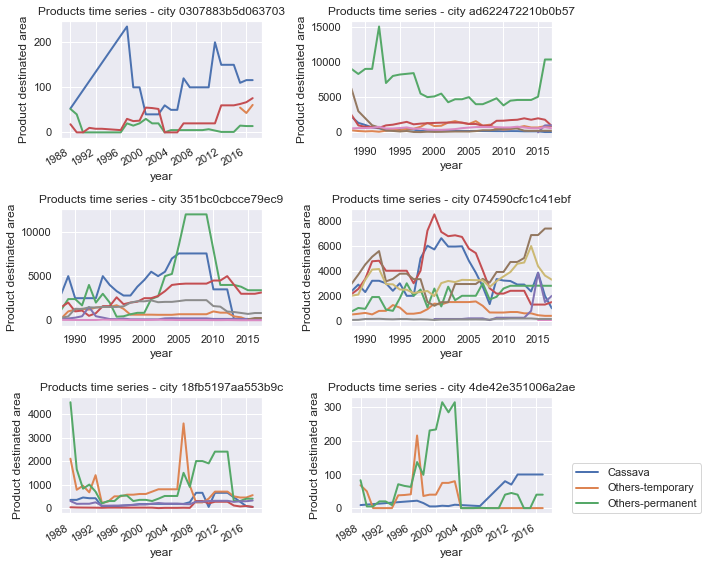

In [277]:
plot_n_cities(ts_ij, cities, n_cities=6)

### 5.5 Visualizando conjuntos de séries temporais por produto

In [274]:
def plot_products_series(ts_ij, prods):
    cities = list(ts_ij.keys())
    fig = plt.figure(figsize=(12,12.5), tight_layout=True)
    axes = [fig.add_subplot(5, 3, i) for i in range(1, len(prods)+1)]
    for city in cities:
        i = ts_ij[city]
        for product, ax in zip(prods, axes):
            ax.set(title='Time series - product ' + product, ylabel='City destinated area')
            if product in i.keys():
                ij = i[product]
                if len(ij): 
                    ij[target].plot(ax=ax, lw=2)
    # ax.legend(loc='best')
    plt.savefig('plots/Séries Temporais por Produto-Tipo.png')
    plt.show()

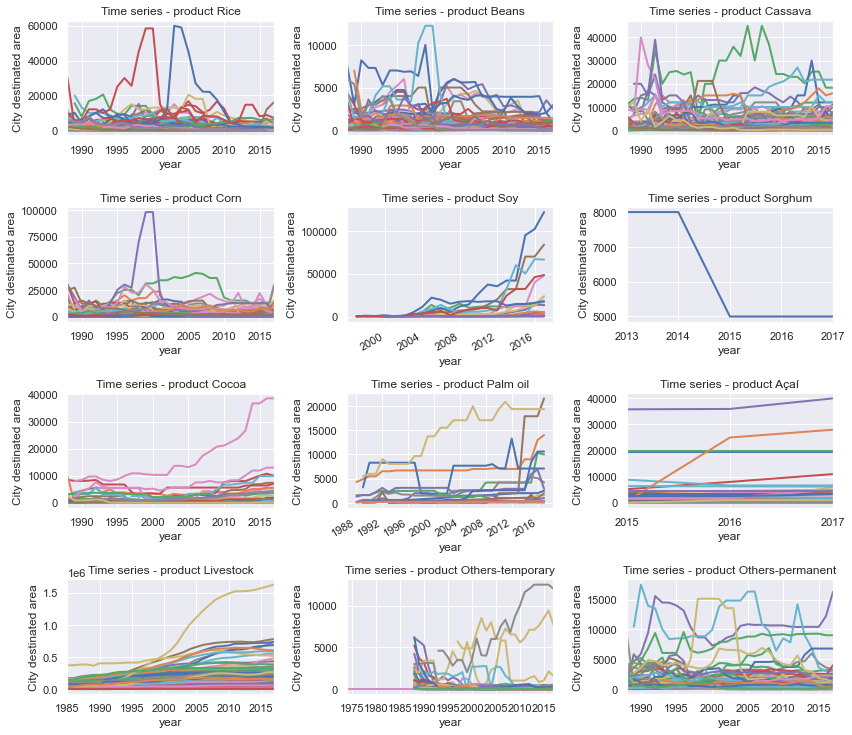

In [275]:
plot_products_series(ts_ij, prods)

---
# EXTRA

#### Setting label encoded index

In [10]:
lab_series = {}
for key in keys:
    lab_series[key] = series[key].set_index(LE.transform(series[key]['year']))[target]

#### Spliting train and test series

In [11]:
tt_series = {}
for key in keys:
    tt_series[key] = {'train': dt_series[key][:'2015'].copy(), 'test': dt_series[key]['2016':].copy()}

In [12]:
tt_lab_series = {}
for key in keys:
    msk = lab_series[key].index.isin([42, 43])
    tt_lab_series[key] = {'train': lab_series[key][msk==False].copy(), 'test': lab_series[key][msk].copy()}